In [ ]:
import gym
import numpy as np
from gym import spaces
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
from dd_class import Dragodinde
from dd_class import Elevage
import random
import time


In [ ]:
class ElevageEnv(gym.Env):
    def __init__(self, elevage):
        super(ElevageEnv, self).__init__()
        self.elevage = elevage

        # Define the action and observation space
        self.action_space = spaces.Discrete(len(elevage.dragodindes) ** 2)
        self.observation_space = spaces.Box(
            low=0, high=10, shape=(len(elevage.dragodindes), 4), dtype=np.float32)

        self.state = self._get_observation()
        self.current_step = 0
        self.max_steps = 1000
        self.max_generations = 10
        self.generation = 1

    def _get_observation(self):
        """
        Returns the current observation of the environment.
        The observation could be the current state of all dragodindes in the elevage.
        Each dragodinde might have features such as gender, color, generation, etc.
        """
        obs = []
        for dragodinde in self.elevage.dragodindes:
            obs.append([dragodinde.id, dragodinde.generation, self._encode_gender(dragodinde.gender), self._encode_color(dragodinde.color)])
        return np.array(obs, dtype=np.float32)

    def _encode_gender(self, gender):
        """Encodes gender as a numerical value."""
        return 1 if gender == "M" else 0

    def _encode_color(self, color):
        """Encodes color as a numerical value. Extend this method if more colors are introduced."""
        color_encoding = {"Rousse": 0, "Amande": 1, "Dorée": 2}
        return color_encoding.get(color, -1)  # Default to -1 if color not found

    def step(self, action):
        """
        Apply the action and return the next state, reward, done, and info.
        """
        assert self.action_space.contains(action)
        self.current_step += 1

        # Define the logic for updating the state based on the action
        # For now, let's assume action is an index to select two dragodindes for breeding
        dragodinde_1_idx = action // len(self.elevage.dragodindes)
        dragodinde_2_idx = action % len(self.elevage.dragodindes)

        self._breed_dragodindes(dragodinde_1_idx, dragodinde_2_idx)

        # Calculate the reward based on the action
        next_state, reward, done, info = self._calculate_reward(action)

        if self.current_step >= self.max_steps:
            done = True

        self.state = self._get_observation()

        return self.state, reward, done, info

    def _breed_dragodindes(self, idx1, idx2):
        """
        Simulates the breeding of two dragodindes and updates the elevage state.
        This is a placeholder method and should be replaced with actual breeding logic.
        """
        if idx1 != idx2:  # Ensure that the same dragodinde is not breeding with itself
            parent_1 = self.elevage.dragodindes[idx1]
            parent_2 = self.elevage.dragodindes[idx2]
            # Implement actual breeding logic here and update self.elevage.dragodindes
            # For simplicity, assume a new dragodinde is created with generation + 1
            new_dragodinde = Dragodinde(
                id=len(self.elevage.dragodindes) + 1,
                gender="M" if np.random.rand() > 0.5 else "F",
                color=parent_1.color,  # Assume the new dragodinde inherits color from parent_1
                generation=max(parent_1.generation, parent_2.generation) + 1
            )
            self.elevage.dragodindes.append(new_dragodinde)

    def _calculate_reward(self, action):
        """
        Calculates the reward based on the action and the current state of the environment.
        """
        reward = 0
        done = False
        info = {}

        if self.generation >= self.max_generations:
            done = True
            reward = 1000  # High reward for completing the maximum generations

        elif action == self.generation:
            reward = 100  # Positive reward for advancing the generation

        elif action > self.generation:
            reward = 50  # Smaller reward for valid actions advancing the generation

        elif action < self.generation - 2:
            reward = -100  # Penalty for regressing too far back in generations

        return self.state, reward, done, info

    def reset(self):
        """
        Resets the environment to an initial state and returns the initial observation.
        """
        self.current_step = 0
        self.generation = 1
        self.elevage = self.create_elevage()
        self.state = self._get_observation()
        return self.state

    def render(self, mode='human'):
        """
        Renders the current state of the environment.
        """
        print(f"Generation: {self.generation}, State: {self.state}")

    def create_elevage(self):
        """
        Initializes a new Elevage with a predefined set of dragodindes.
        """
        dragodindes_data = [
            (1, "M", "Rousse", 1),
            (2, "F", "Rousse", 1),
            (3, "M", "Amande", 1),
            (4, "F", "Amande", 1),
            (5, "M", "Dorée", 1),
            (6, "F", "Dorée", 1)
        ]

        list_dd = []
        for id, gender, color, generation in dragodindes_data:
            dragodinde = Dragodinde(id, gender, color, generation)
            list_dd.append(dragodinde)

        return Elevage(list_dd)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [8]:
class Models :
    def __init__(self) :
        self.elevage = self.create_elevage()

    def __str__(self) :
        return (f"{self.elevage}")
    
    def get_length_elevage(self) :
        return len(self.elevage.get_dragodindes())
    
    def get_better_generation(self) :
        better_generation = 1
        for dragodinde in self.elevage.get_dragodindes() :
            generation = dragodinde.get_generation()
            if generation > better_generation :
                better_generation = generation
        
        return better_generation

    def get_dd_better_generation(self, dragodindes) :
        better_generation = 1
        list_better_dd = []
        for idx, dragodinde in enumerate(dragodindes) :
            generation  = dragodinde.get_generation()
            if generation > better_generation :
                list_better_dd = []
                better_generation = generation
                list_better_dd.append(dragodindes[idx])
            elif generation == better_generation :
                list_better_dd.append(dragodindes[idx])

        return list_better_dd

    def create_elevage(self):

        dragodindes_data = [
            (1, "M", "Rousse", 1),
            (2, "F", "Rousse", 1),
            (3, "M", "Amande", 1),
            (4, "F", "Amande", 1),
            (5, "M", "Dorée", 1),
            (6, "F", "Dorée", 1)
        ]

        list_dd = []
        for id, gender, color, generation in dragodindes_data:
            dragodinde = Dragodinde(id, gender, color, generation)
            list_dd.append(dragodinde)

        return Elevage(list_dd)
    
    def strategy_random_crosing(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        male = random.choice(males)
        female = random.choice(females)

        # Assuming accouplement_naissance is a method that performs crossing and returns probabilities
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)

        return nouvelle_dd
    
    def strategy_crosing_better_gen(self):
        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]

        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")

        # Take the best generation
        list_better_males = self.get_dd_better_generation(males)
        list_better_females = self.get_dd_better_generation(females)

        if list_better_males[0].get_generation() > list_better_females[0].get_generation():
            male = random.choice(males)
            female = random.choice(list_better_females)
        
        elif list_better_males[0].get_generation() < list_better_females[0].get_generation():
            male = random.choice(list_better_males)
            female = random.choice(females)

        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        return nouvelle_dd

    def strategy_select_and_purify(self) :
        # Intuition :
        # Has a snakemake identify what are the dd need it to create a 10th generation dd 
        # Indentify dd that need to be crossing (while the n-1 generation dd is available)
        # Purify and Lock the select dd (M AND F)
        # While a selected dd is identify (color) and gen n - 1 is purify 
        # do crossing / purification step 
        # ...

        males = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "M"]
        females = [dd for dd in self.elevage.get_dragodindes() if dd.get_sex() == "F"]
        
        if not males or not females:
            raise ValueError("No suitable pairs for crossing.")
        
        # bicolor and mono color 
        bicolor_special_cases = self.elevage.get_special_cases_keys()
        monocolor = self.elevage.get_generation().get_list_monocolor()

        # purify the actual generation
        # Take the best generation
        list_better_males = self.get_dd_better_generation(males)
        list_better_females = self.get_dd_better_generation(females)

        # Add special case where generation are on a bicolor step

        # check if male and female are pure 
        male_pur = []
        female_pur = []
        for male_dd in list_better_males :
            nodes_male = male_dd.get_arbre_genealogique().get_genealogie().get_all_nodes()
            color_ind_male = nodes_male[0].get_color()
            for node in nodes_male : 
                if node.get_color() != color_ind_male : 
                    break
            male_pur.append(male_dd)

        for female_dd in list_better_females :
            nodes_female = female_dd.get_arbre_genealogique().get_genealogie().get_all_nodes()
            color_ind_female = nodes_female[0].get_color()
            for node in nodes_female : 
                if node.get_color() != color_ind_female : 
                    break
            female_pur.append(male_dd)

        # Check if both are compitable (mono/mono same gen) or (bi/bi = special case)
        
        # Crossing each other
        nouvelle_dd, _ = self.elevage.accouplement_naissance(male, female)
        return nouvelle_dd
    
import matplotlib.pyplot as plt
 
def plot_simlation(list_simulation) : 
    x_values = list(range(len(list_simulation)))

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plotting the two lists
    plt.plot(x_values, list_simulation, label='Generation List', color='blue')
    plt.ylim(0, 11)

    # Adding labels and title
    plt.xlabel('Number of Croisement')
    plt.ylabel('Generation Number')
    plt.title('Plot of Generation Numbers per Croisement')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()


In [18]:
elevage = Models()
list_random = [1]
better_generation = 1
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_random_crosing()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_random.append(better_generation)

In [19]:
elevage = Models()
better_generation = 1
list_gen_upgrade_random = [1]
crosing_number = 1000
for i in range(crosing_number) :
    new_dd = elevage.strategy_crosing_better_gen()
    generation = new_dd.get_generation()
    if generation > better_generation :
        better_generation = generation
    list_gen_upgrade_random.append(better_generation)

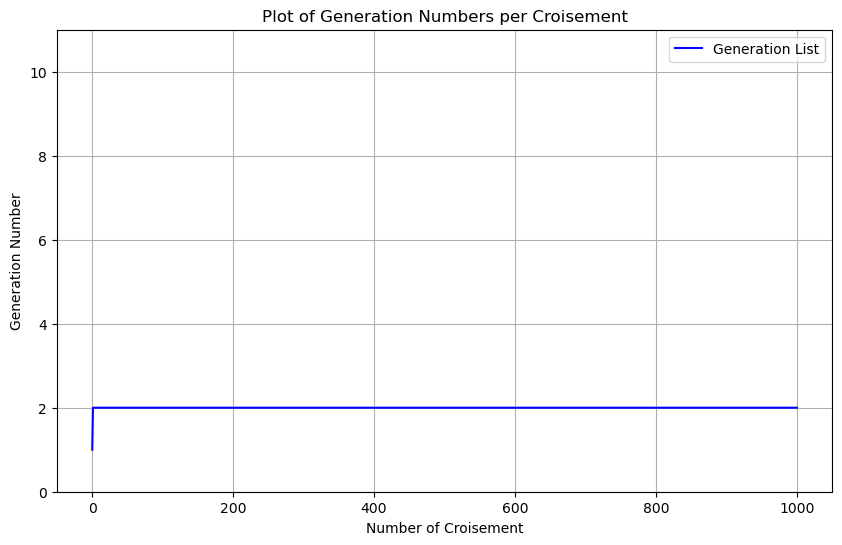

In [27]:
plot_simlation(list_random) 

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]


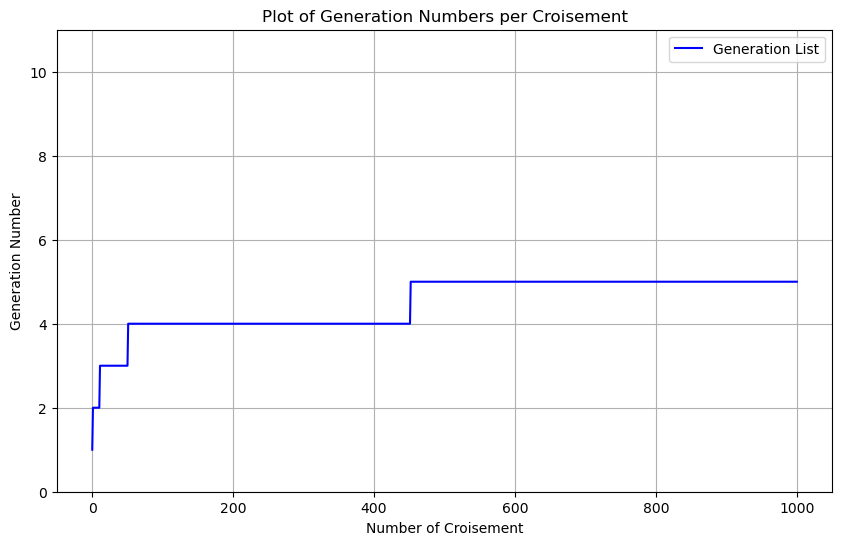

In [21]:
plot_simlation(list_gen_upgrade_random) 

In [23]:
list_simulation_random = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_random_crosing()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_random.append(list_gen_upgrade_random)

In [24]:
list_simulation_better_gen = []

for i in range(100) :
    elevage = Models()
    list_gen_upgrade_random = [1]
    crosing_number = 1000
    better_generation = 1
    for i in range(crosing_number) :
        new_dd = elevage.strategy_crosing_better_gen()
        generation = new_dd.get_generation()
        if generation > better_generation :
            better_generation = generation
        list_gen_upgrade_random.append(better_generation)
    list_simulation_better_gen.append(list_gen_upgrade_random)

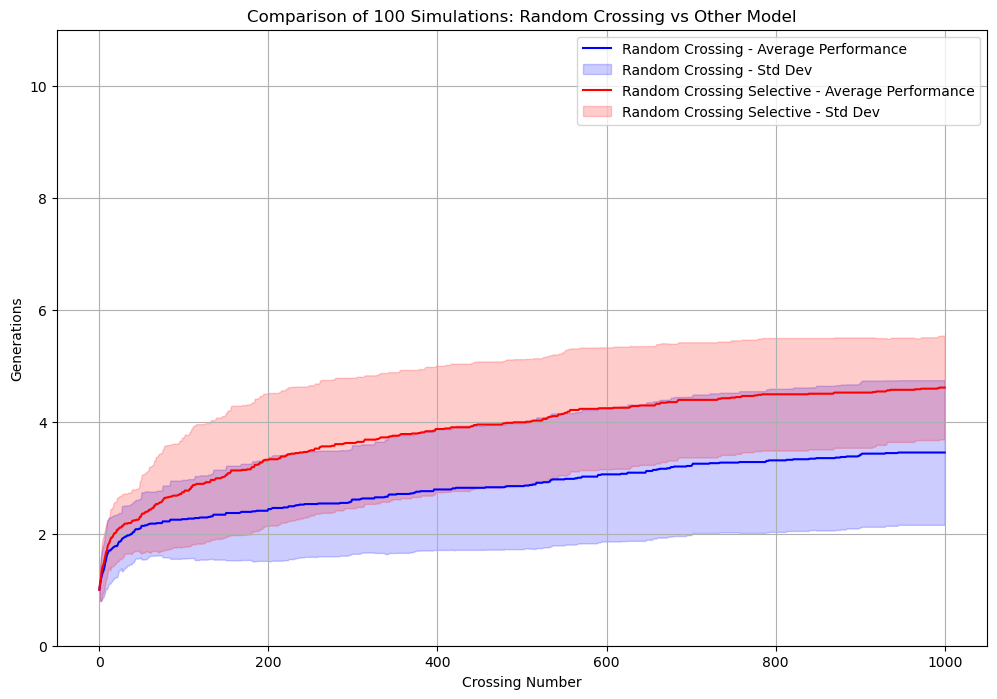

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Convert both to numpy arrays for easy aggregation
simulation_random_array = np.array(list_simulation_random)
simulation_other_array = np.array(list_simulation_better_gen)

# Calculate mean and standard deviation across simulations for both models
mean_performance_random = np.mean(simulation_random_array, axis=0)
std_performance_random = np.std(simulation_random_array, axis=0)

mean_performance_other = np.mean(simulation_other_array, axis=0)
std_performance_other = np.std(simulation_other_array, axis=0)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot for Random Crossing model
plt.plot(mean_performance_random, label='Random Crossing - Average Performance', color='blue')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_random - std_performance_random, 
                 mean_performance_random + std_performance_random, 
                 color='blue', alpha=0.2, label='Random Crossing - Std Dev')

# Plot for Other model
plt.plot(mean_performance_other, label='Random Crossing Selective - Average Performance', color='red')
plt.fill_between(range(crosing_number + 1), 
                 mean_performance_other - std_performance_other, 
                 mean_performance_other + std_performance_other, 
                 color='red', alpha=0.2, label='Random Crossing Selective - Std Dev')

# Customize the plot
plt.title('Comparison of 100 Simulations: Random Crossing vs Other Model')
plt.xlabel('Crossing Number')
plt.ylabel('Generations')
plt.ylim(0, 11)  # Set y-axis limits from 0 to 11
plt.legend()
plt.grid(True)
plt.show()